# Automated CapsnetsS2I train + test

First, import stuff

In [7]:
import model_s2i
import data_loader
import tensorflow as tf

In [8]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [9]:
WORD_VEC_SCENARIO = "FastText-300-verbsDatasets-synAntVSP-dia"
SCENARIO_NAME = 'rerouting-3-attention-masked'

word2vec_path = '../../romanian_word_vecs/cleaned-vectors-diacritice.vec'

# No diacritics data
training_data_paths = [
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
        '../data-capsnets/diacritics/scenario0/train.txt',
        '../data-capsnets/diacritics/scenario1/train.txt',
        '../data-capsnets/diacritics/scenario2/train.txt',
        '../data-capsnets/diacritics/scenario31/train.txt',
        '../data-capsnets/diacritics/scenario32/train.txt',
        '../data-capsnets/diacritics/scenario33/train.txt',
        
    ]
test_data_paths = [
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
    '../data-capsnets/diacritics/scenario0/test.txt',
    '../data-capsnets/diacritics/scenario1/test.txt',
    '../data-capsnets/diacritics/scenario2/test.txt',
    '../data-capsnets/diacritics/scenario31/test.txt',
    '../data-capsnets/diacritics/scenario32/test.txt',
    '../data-capsnets/diacritics/scenario33/test.txt',
]

scenario_nums = [
#     '0_' + WORD_VEC_SCENARIO,
#     '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
#     '0_dia_' + WORD_VEC_SCENARIO,
#     '1_dia_' + WORD_VEC_SCENARIO,
#     '2_dia_' + WORD_VEC_SCENARIO,
#     '31_dia_' + WORD_VEC_SCENARIO,
#     '32_dia_' + WORD_VEC_SCENARIO,
#     '33_dia_' + WORD_VEC_SCENARIO,
    '0-' + SCENARIO_NAME,
    '1-' + SCENARIO_NAME,
    '2-' + SCENARIO_NAME,
    '31-' + SCENARIO_NAME,
    '32-' + SCENARIO_NAME,
    '33-' + SCENARIO_NAME,
]

In [10]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took 000.11
------------------load word2vec end---------------------


# Flag setting functions + utils

In [13]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    tf.app.flags.DEFINE_string('results_dir', './results/', 'Results dir')
    tf.app.flags.DEFINE_string('hyperparams_dir', './hyperparams/', 'Hyperparams dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 64

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 16, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 20, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 3, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    tf.app.flags.DEFINE_float('rerouting_coef', 0.5, 'coefficient for rerouting')
    tf.app.flags.DEFINE_boolean('use_rerouting', True, 'whether to use rerouting or not')
    tf.app.flags.DEFINE_boolean('use_attention', True,
                                'whether to use attention or not. If attention is used,'
                                'slot_output_dim will be overridden to hidden_size * 2')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results/results_{}.csv'.format(SCENARIO_NAME), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [12]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
max length is 15
max length is 15
------------------read datasets end---------------------
TRAINING 0-rerouting-3-attention-masked
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.071429
F score 0.071429
Slot filling
F1 score: 0.007128
Accuracy: 0.109048
------------------epoch :  0  Loss:  15.504138 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.530952
F score 0.530952
Slot filling
F1 score: 0.435780
Accuracy: 0.925873
Current F score mean 0.48336609873307124
Best F score mean 0.48336609873307124
------------------epoch :  1  Loss:  1.5083908 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.835714
F score 0.835714


------------------epoch :  5  Loss:  0.010941701 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.959524
F score 0.959524
Slot filling
F1 score: 0.993915
Accuracy: 0.999524
Current F score mean 0.9767193084130203
Best F score mean 0.9892564402810304
------------------epoch :  6  Loss:  0.010408001 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.973810
F score 0.973810
Slot filling
F1 score: 0.987830
Accuracy: 0.999206
Current F score mean 0.9808195692069932
Best F score mean 0.9892564402810304
------------------epoch :  7  Loss:  0.0066073993 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.969048
F score 0.969048
Slot filling
F1 score: 0.994914
Accuracy: 0.999524
Current F score mean 0.9819805745288961
Best F score mean 0.9892564402810304
------------------epoch :  8  Loss:  0.006259826 ----------------------
           V

------------------epoch :  11  Loss:  0.002920801 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.981818
Accuracy: 0.998730
Current F score mean 0.9897186147186147
Best F score mean 0.9977932636469222
------------------epoch :  12  Loss:  0.0027098176 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.981818
Accuracy: 0.998730
Current F score mean 0.9897186147186147
Best F score mean 0.9977932636469222
------------------epoch :  13  Loss:  0.0025374582 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.981818
Accuracy: 0.998730
Current F score mean 0.9897186147186147
Best F score mean 0.9977932636469222
------------------epoch :  14  Loss:  0.002392934 ----------------------
       

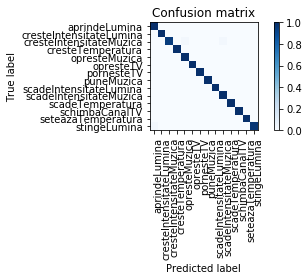

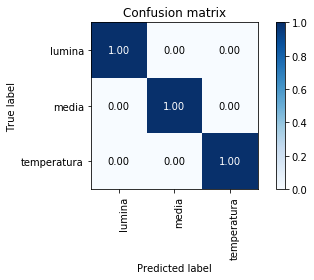

Intent F1: 0.994643
Slot F1: 0.996180
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 1-rerouting-3-attention-masked
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.081081
F score 0.081081
Slot filling
F1 score: 0.020198
Accuracy: 0.174710
------------------epoch :  0  Loss:  9.075468 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.759459
F score 0.759459
Slot filling
F1 score: 0.465753
Accuracy: 0.925676
Current F score mean 0.6126064420584969
Best F score mean 0.6126064420584969
------------------epoch :  1  Loss:  1.2413638 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent 

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.989189
F score 0.989189
Slot filling
F1 score: 0.986472
Accuracy: 0.997683
Current F score mean 0.9878308068734707
Best F score mean 0.9994913530010172
------------------epoch :  5  Loss:  0.010704692 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.982347
Accuracy: 0.998263
Current F score mean 0.9911734164070614
Best F score mean 0.9994913530010172
------------------epoch :  6  Loss:  0.005536937 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.994786
Accuracy: 0.999035
Current F score mean 0.997393117831074
Best F score mean 0.9994913530010172
------------------epoch :  7  Loss:  0.004011963 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.00000

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.993802
Accuracy: 0.999224
Current F score mean 0.9969008264462811
Best F score mean 0.9994913530010172
------------------epoch :  11  Loss:  0.0021556406 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.993802
Accuracy: 0.999224
Current F score mean 0.9969008264462811
Best F score mean 0.9994913530010172
------------------epoch :  12  Loss:  0.0019890573 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.993802
Accuracy: 0.999224
Current F score mean 0.9969008264462811
Best F score mean 0.9994913530010172
------------------epoch :  13  Loss:  0.0018515345 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 

<Figure size 432x288 with 0 Axes>

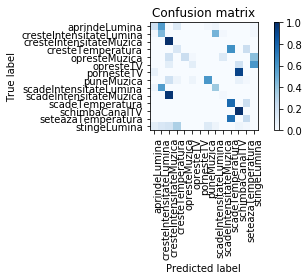

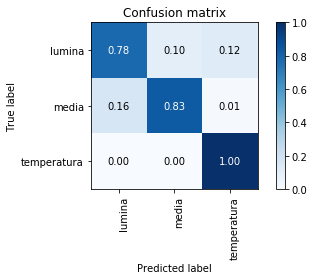

Intent F1: 0.367857
Slot F1: 0.753643
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 2-rerouting-3-attention-masked
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.063444
F score 0.063444
Slot filling
F1 score: 0.034616
Accuracy: 0.072508
------------------epoch :  0  Loss:  19.65801 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.634441
F score 0.634441
Slot filling
F1 score: 0.307692
Accuracy: 0.911739
Current F score mean 0.4710666976528004
Best F score mean 0.4710666976528004
------------------epoch :  1  Loss:  3.5309806 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent 

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996692
Accuracy: 0.999353
Current F score mean 0.9983461962513782
Best F score mean 0.9983461962513782
------------------epoch :  5  Loss:  0.01327128 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996692
Accuracy: 0.999353
Current F score mean 0.9983461962513782
Best F score mean 0.9983461962513782
------------------epoch :  6  Loss:  0.010865416 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996692
Accuracy: 0.999353
Current F score mean 0.9983461962513782
Best F score mean 0.9983461962513782
------------------epoch :  7  Loss:  0.009429604 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.00000

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997826
Accuracy: 0.999784
Current F score mean 0.9989130434782609
Best F score mean 0.9989130434782609
------------------epoch :  11  Loss:  0.0061850166 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997826
Accuracy: 0.999784
Current F score mean 0.9989130434782609
Best F score mean 0.9989130434782609
------------------epoch :  12  Loss:  0.0059004882 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997826
Accuracy: 0.999784
Current F score mean 0.9989130434782609
Best F score mean 0.9989130434782609
------------------epoch :  13  Loss:  0.005673414 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1

<Figure size 432x288 with 0 Axes>

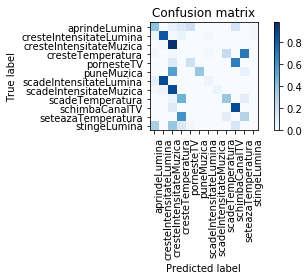

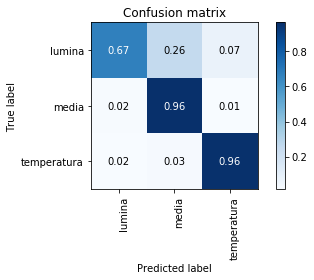

Intent F1: 0.368750
Slot F1: 0.459046
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 31-rerouting-3-attention-masked
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.011152
F score 0.011152
Slot filling
F1 score: 0.027262
Accuracy: 0.011418
------------------epoch :  0  Loss:  21.053158 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.691450
F score 0.691450
Slot filling
F1 score: 0.276860
Accuracy: 0.904673
Current F score mean 0.4841546591293127
Best F score mean 0.4841546591293127
------------------epoch :  1  Loss:  5.8620596 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Inten

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.988848
F score 0.988848
Slot filling
F1 score: 0.984709
Accuracy: 0.997876
Current F score mean 0.9867785318827234
Best F score mean 0.9913468687446383
------------------epoch :  5  Loss:  0.02668108 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.977695
F score 0.977695
Slot filling
F1 score: 0.990826
Accuracy: 0.998407
Current F score mean 0.9842604276798199
Best F score mean 0.9913468687446383
------------------epoch :  6  Loss:  0.019945513 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.988848
F score 0.988848
Slot filling
F1 score: 0.992366
Accuracy: 0.998672
Current F score mean 0.9906069979284315
Best F score mean 0.9913468687446383
------------------epoch :  7  Loss:  0.013826827 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.98513

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992509
F score 0.992509
Slot filling
F1 score: 0.978916
Accuracy: 0.996522
Current F score mean 0.9857125129732413
Best F score mean 0.9913468687446383
------------------epoch :  11  Loss:  0.01544399 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992509
F score 0.992509
Slot filling
F1 score: 0.978916
Accuracy: 0.996522
Current F score mean 0.9857125129732413
Best F score mean 0.9913468687446383
------------------epoch :  12  Loss:  0.012604931 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992509
F score 0.992509
Slot filling
F1 score: 0.978916
Accuracy: 0.996522
Current F score mean 0.9857125129732413
Best F score mean 0.9913468687446383
------------------epoch :  13  Loss:  0.010549058 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.99

<Figure size 432x288 with 0 Axes>

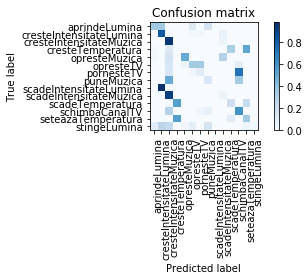

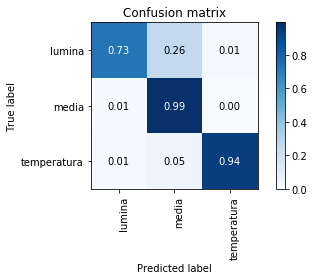

Intent F1: 0.317857
Slot F1: 0.446043
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 32-rerouting-3-attention-masked
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.111111
F score 0.111111
Slot filling
F1 score: 0.060146
Accuracy: 0.187566
------------------epoch :  0  Loss:  17.735806 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.607407
F score 0.607407
Slot filling
F1 score: 0.590818
Accuracy: 0.948942
Current F score mean 0.5991128853404303
Best F score mean 0.5991128853404303
------------------epoch :  1  Loss:  4.630359 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.981481
F score 0.981481
Slot filling
F1 score: 0.939641
Accuracy: 0.993386
Current F score mean 0.9605612953900067
Best F score mean 0.9839255499153976
------------------epoch :  5  Loss:  0.08093613 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.996296
F score 0.996296
Slot filling
F1 score: 0.976821
Accuracy: 0.995767
Current F score mean 0.9865587441746382
Best F score mean 0.9865587441746382
------------------epoch :  6  Loss:  0.030294623 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992593
F score 0.992593
Slot filling
F1 score: 0.963816
Accuracy: 0.995767
Current F score mean 0.9782041910331384
Best F score mean 0.9865587441746382
------------------epoch :  7  Loss:  0.02859288 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.988889

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.981343
F score 0.981343
Slot filling
F1 score: 0.973244
Accuracy: 0.997068
Current F score mean 0.9772937153696402
Best F score mean 0.9867549668874172
------------------epoch :  11  Loss:  0.0168001 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.981343
F score 0.981343
Slot filling
F1 score: 0.976589
Accuracy: 0.997335
Current F score mean 0.9789659561723157
Best F score mean 0.9867549668874172
------------------epoch :  12  Loss:  0.013485441 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.981343
F score 0.981343
Slot filling
F1 score: 0.976589
Accuracy: 0.997335
Current F score mean 0.9789659561723157
Best F score mean 0.9867549668874172
------------------epoch :  13  Loss:  0.011897806 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.981

<Figure size 432x288 with 0 Axes>

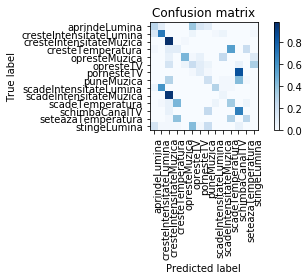

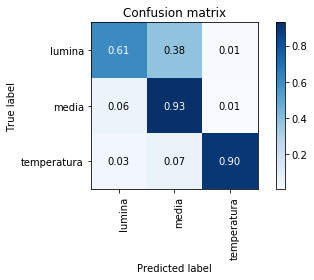

Intent F1: 0.333929
Slot F1: 0.413084
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 33-rerouting-3-attention-masked
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.015152
F score 0.015152
Slot filling
F1 score: 0.084382
Accuracy: 0.137085
------------------epoch :  0  Loss:  21.21553 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.489899
F score 0.489899
Slot filling
F1 score: 0.353659
Accuracy: 0.875180
Current F score mean 0.4217787632421779
Best F score mean 0.4217787632421779
------------------epoch :  1  Loss:  7.740484 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent 

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.959596
F score 0.959596
Slot filling
F1 score: 0.986343
Accuracy: 0.996753
Current F score mean 0.9729694517251422
Best F score mean 0.9889793456957636
------------------epoch :  5  Loss:  0.056614872 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.959596
F score 0.959596
Slot filling
F1 score: 0.984894
Accuracy: 0.996753
Current F score mean 0.9722451097073453
Best F score mean 0.9889793456957636
------------------epoch :  6  Loss:  0.59157854 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.989899
F score 0.989899
Slot filling
F1 score: 0.980451
Accuracy: 0.995671
Current F score mean 0.9851750588592694
Best F score mean 0.9889793456957636
------------------epoch :  7  Loss:  0.49311152 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.979798

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.989899
F score 0.989899
Slot filling
F1 score: 0.984848
Accuracy: 0.996753
Current F score mean 0.9873737373737373
Best F score mean 0.9914324514022399
------------------epoch :  11  Loss:  0.082437985 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.979798
F score 0.979798
Slot filling
F1 score: 0.984848
Accuracy: 0.996753
Current F score mean 0.9823232323232323
Best F score mean 0.9914324514022399
------------------epoch :  12  Loss:  0.015443735 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.984848
F score 0.984848
Slot filling
F1 score: 0.984848
Accuracy: 0.996753
Current F score mean 0.9848484848484849
Best F score mean 0.9914324514022399
------------------epoch :  13  Loss:  0.01401877 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.98

<Figure size 432x288 with 0 Axes>

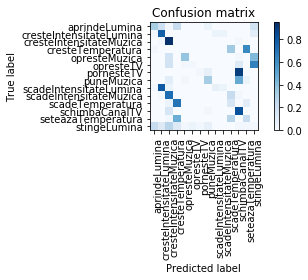

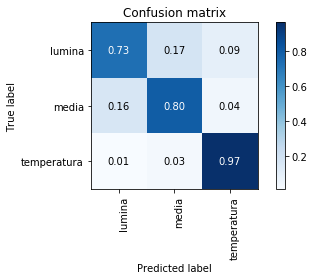

Intent F1: 0.293381
Slot F1: 0.409722


<Figure size 432x288 with 0 Axes>

In [14]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(model_s2i.CapsNetS2I, data, FLAGS, batches_rand=False)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(model_s2i.CapsNetS2I, data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)